# **DDPM: Denoising Diffusion Probabilistic Models**

This lecture is inspired by the [How Diffusion Models Work (by Sharon Zhou) Course](https://www.deeplearning.ai/short-courses/how-diffusion-models-work/).

In this exercise we will see the DDPM models, described for the first time by [Ho et al. (2020)](https://arxiv.org/pdf/2006.11239.pdf), in particular a very simple implementation of a peculiar task: creating sprites for old school 2D GDR games.



---

### **The Dataset**

The dataset provided by the course, is a collection of 16x16 images; each image is labbeled with one of these classes: *hero*, *non-hero*, *food*, *spells&weapons* and *side-facing*.



In [1]:
import gdown
gdown.download("https://drive.google.com/uc?id=1XTxuKx78vHl65sD4azxzGlH1fN-Cvlgj", "data.gz", quiet=False)
gdown.download("https://drive.google.com/uc?id=1UJGIfYt7Iri8uakh71hn2cqhKc3KIZgr", "UNET.png", quiet=False)

!tar -xzf data.gz

Downloading...
From: https://drive.google.com/uc?id=1XTxuKx78vHl65sD4azxzGlH1fN-Cvlgj
To: /content/data.gz
100%|██████████| 20.4M/20.4M [00:00<00:00, 42.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UJGIfYt7Iri8uakh71hn2cqhKc3KIZgr
To: /content/UNET.png
100%|██████████| 37.2k/37.2k [00:00<00:00, 68.3MB/s]


imgs.shape: (89400, 16, 16, 3)
labels.shape: (89400, 5)


Image dimension: (16, 16, 3)
Label: [1. 0. 0. 0. 0.]


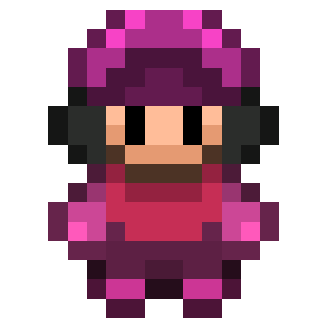

In [2]:
import matplotlib.pyplot as plt
import numpy as np

IMGS = "sprites_16x16.npy"
LABELS = "sprites_labels.npy"

imgs = np.load(IMGS)
labels = np.load(LABELS)

print(f"imgs.shape: {imgs.shape}")
print(f"labels.shape: {labels.shape}")


print(f"\n\nImage dimension: {imgs[0].shape}")
print(f"Label: {labels[0]}")

plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(imgs[0], cmap="gray")
plt.show()

In [3]:
MAP_LABELS = {0: "hero", 1: "non-hero", 2: "food", 3: "spells&weapons", 4: "side-facing"}
str_labels = [MAP_LABELS[l.index(1.0)] for l in labels.tolist()]

for l in MAP_LABELS.values():
    print(f"{l}: {str_labels.count(l)}")

hero: 8000
non-hero: 32400
food: 6000
spells&weapons: 35000
side-facing: 8000


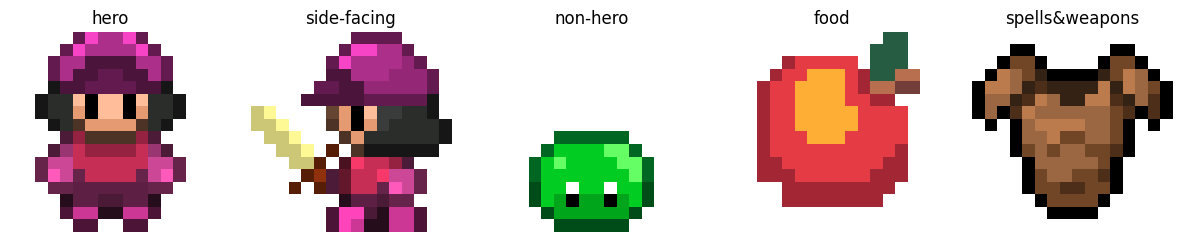

In [4]:
import matplotlib.pyplot as plt

plotted_ind = {"hero": False, "non-hero": False, "food": False, "spells&weapons": False, "side-facing": False}

fig, ax = plt.subplots(1, len(MAP_LABELS), figsize=(15, 15))

i = 0
for img, lbl in zip(imgs.tolist(), labels.tolist()):

    if not plotted_ind[MAP_LABELS[lbl.index(1.0)]]:
        plotted_ind[MAP_LABELS[lbl.index(1.0)]] = True
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(MAP_LABELS[lbl.index(1.0)])
        i += 1

        if i == 5:
            break

plt.show()

In [5]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms


class SpriteDataset(Dataset):

    def __init__(self, imgs, labels, normalization):
        super(SpriteDataset, self).__init__()

        self.sprites = np.load(imgs)
        self.labels = np.load(labels)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(*normalization)
        ])

    def __len__(self):
        return len(self.sprites)


    def __getitem__(self, idx):
        return self.transform(self.sprites[idx]), torch.tensor(self.labels[idx], dtype=torch.float32)

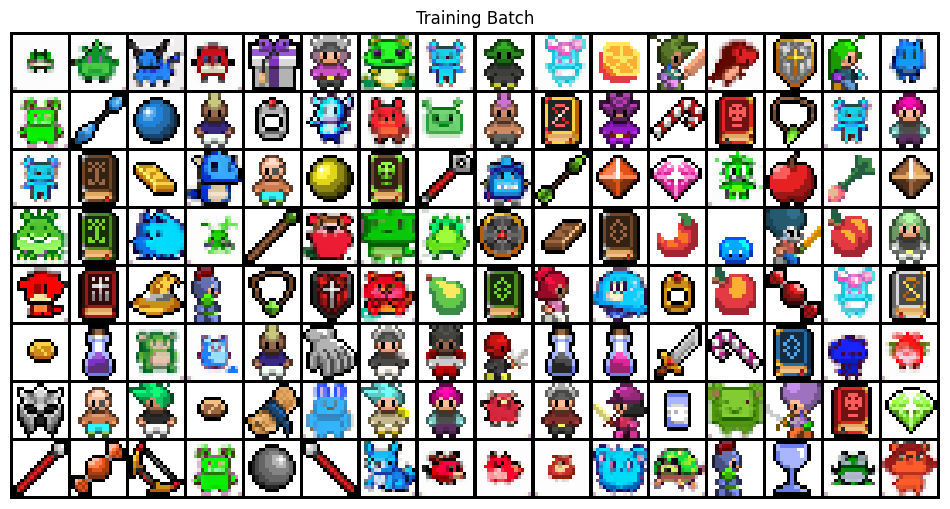

In [6]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt


NORMALIZATION = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
BATCH_SIZE = 128


def denorm(image):
    return image * NORMALIZATION[1][0] + NORMALIZATION[0][0]


dataset = SpriteDataset(IMGS, LABELS, NORMALIZATION)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for imgs, _ in dataloader:

    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title("Training Batch")
    plt.imshow(np.transpose(vutils.make_grid([denorm(img) for img in imgs], nrow=16, padding=1), (1, 2, 0)))

    break


---

### **The Denoising Architecture**

Finally, in this section we will start coding first the single blocks and then the full UNet architecture.

**Individual blocks**

In [7]:
import math
import torch.nn as nn


class ResidualConvBlock(nn.Module):
    """
    Residual Convolutional Block with optional residual connection.
    Applies two convolutions with GroupNorm and GELU activation.
    """
    def __init__(self, in_channels, out_channels, is_res=False):
        super(ResidualConvBlock, self).__init__()

        self.same_channels = (in_channels == out_channels)
        self.is_res = is_res

        # First convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU()
        )

        # Second convolution block
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, out_channels),
            nn.GELU()
        )

    def forward(self, x):
        if self.is_res:
            # Apply convolutions
            x1 = self.conv1(x)
            x2 = self.conv2(x1)

            # Add residual connection if channels match
            if self.same_channels:
                out = x + x2
            else:
                # Use first conv output as residual when channels don't match
                out = x1 + x2

            return out / 1.414  # Normalize to prevent variance explosion
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

In [8]:
# Downsampling block
class UnetDown(nn.Module):
    """
    UNet Downsampling Block.
    Applies residual convolutions followed by max pooling.
    """
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Sequence of operations: ResBlock -> ResBlock -> MaxPool
        self.model = nn.Sequential(
            ResidualConvBlock(in_channels, out_channels, is_res=True),
            ResidualConvBlock(out_channels, out_channels, is_res=True),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Upsampling block
class UnetUp(nn.Module):
    """
    UNet Upsampling Block.
    Applies upsampling followed by residual convolutions.
    Uses skip connections from encoder.
    """
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Sequence of operations: Upsample -> ResBlock -> ResBlock
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            ResidualConvBlock(out_channels, out_channels, is_res=True),
            ResidualConvBlock(out_channels, out_channels, is_res=True)
        )

    def forward(self, x, skip):
        # Concatenate with skip connection from encoder
        x = torch.cat([x, skip], dim=1)
        return self.model(x)

In [10]:
#Embedding block
class EmbedFC(nn.Module):
    """
    Fully Connected Embedding Block.
    Used for embedding timesteps and other conditioning information.
    """
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()

        self.input_dim = input_dim

        # Two-layer MLP with GELU activation
        self.model = nn.Sequential(
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim)
        )

    def forward(self, x):
        # Flatten input if necessary
        x = x.view(-1, self.input_dim)
        return self.model(x)

**The Unet Architecture**

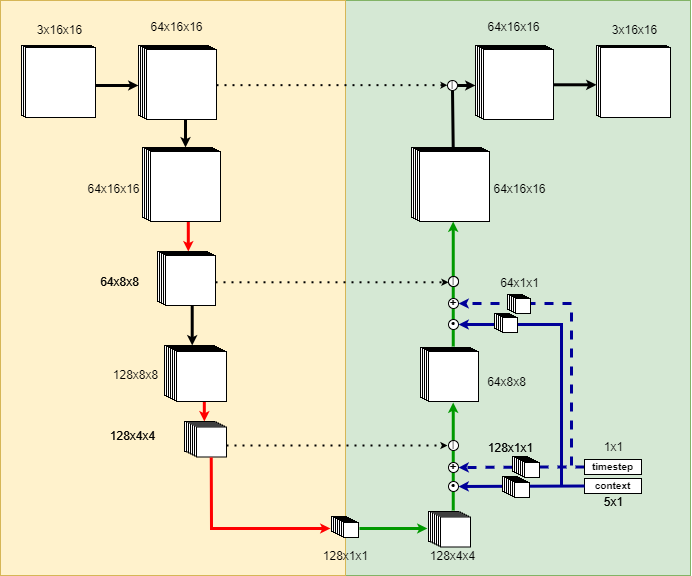

In [11]:
from IPython.display import Image, display
display(Image(filename='UNET.png'))

In [12]:
import torch
import torch.nn as nn
from tqdm import tqdm
import os
import torch.nn.functional as F

SAVE_DIR = './diffusion/'

# helper function: perturbs an image to a specified noise level
def perturb_input(image, timestamp, noise, ab_t):
    return ab_t.sqrt()[timestamp, None, None, None] * image + (1 - ab_t[timestamp, None, None, None]) * noise


class Unet(nn.Module):
    """
    U-Net architecture for diffusion models.
    Takes noisy images and timesteps as input, predicts the noise.
    """

    def __init__(self, in_channels, n_feat=64):
        super(Unet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        # Initial convolution
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Encoder (downsampling path)
        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        # Bottleneck
        self.to_vec = nn.Sequential(
            nn.AvgPool2d(4),
            nn.GELU()
        )

        # Time embedding
        self.timeembed1 = EmbedFC(1, 2 * n_feat)
        self.timeembed2 = EmbedFC(1, n_feat)

        # Decoder (upsampling path)
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, kernel_size=4, stride=4),
            nn.GroupNorm(8, 2 * n_feat),
            nn.GELU()
        )

        # Note: in_channels is doubled due to skip connections
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Output convolution
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, kernel_size=3, stride=1, padding=1),
            nn.GroupNorm(8, n_feat),
            nn.GELU(),
            nn.Conv2d(n_feat, self.in_channels, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x, t):
        """
        Forward pass of the U-Net.

        Args:
            x: Noisy image tensor [batch, channels, height, width]
            t: Timestep tensor [batch, 1, 1, 1] (normalized to [0, 1])

        Returns:
            Predicted noise tensor
        """
        # Initial convolution
        x = self.init_conv(x)

        # Encoder path with skip connections
        down1 = self.down1(x)
        down2 = self.down2(down1)

        # Bottleneck
        hiddenvec = self.to_vec(down2)

        # Time embeddings
        temb1 = self.timeembed1(t).view(-1, 2 * self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        # Decoder path
        up0 = self.up0(hiddenvec)

        # Add time embedding and use skip connection
        up1 = self.up1(up0 + temb1, down2)
        up2 = self.up2(up1 + temb2, down1)

        # Output with skip connection from init_conv
        out = self.out(torch.cat([up2, x], dim=1))

        return out


    def train_diffusion(self, dataloader, n_epoch, criterion, optim, lrate, timesteps, ab_t):
        self.train()

        train_loss = []
        for ep in tqdm(range(n_epoch)):

            epoch_loss = 0.0
            num_batches = 0

            for images, _ in dataloader:
                images = images.to(device)

                optim.zero_grad()

                # Sample random timesteps for each image in batch
                t = torch.randint(1, timesteps + 1, (images.shape[0],)).to(device)

                # Sample noise
                noise = torch.randn_like(images)

                # Perturb images (add noise according to timestep)
                noisy_images = perturb_input(images, t, noise, ab_t)

                # Predict noise
                # Normalize timesteps to [0, 1] for the network
                t_normalized = (t / timesteps)[:, None, None, None].float()
                pred_noise = self(noisy_images, t_normalized)

                # Compute loss between predicted and actual noise
                loss = criterion(pred_noise, noise)

                loss.backward()
                optim.step()

                epoch_loss += loss.item()
                num_batches += 1

            # Record average epoch loss
            train_loss.append(epoch_loss / num_batches)

            # save model periodically
            if ep % 4 == 0 or ep == int(n_epoch-1):
                if not os.path.exists(SAVE_DIR):
                    os.makedirs(SAVE_DIR)

                torch.save(self.state_dict(), SAVE_DIR + f"model_{ep}.pth")
                print('saved model at ' + SAVE_DIR + f"model_{ep}.pth")

        return train_loss


**DDPM Hyperparameters**

In [13]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
print(device)

# diffusion hyperparameters
NUM_TIMESTEPS = 500
BETA1 = 1e-4
BETA2 = 0.02

# construct DDPM noise schedule (as described in the paper)
b_t = (BETA2 - BETA1) * torch.linspace(0, 1, NUM_TIMESTEPS + 1, device=device) + BETA1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()
ab_t[0] = 1

# network hyperparameters
n_feat = 64                 # 64 hidden dimension feature
img_dim = 16                # 16x16 image
color_dim = 3               # 3 color channels

# training hyperparameters
n_epoch = 32
lrate = 1e-3

cuda:0


In [15]:
# construct model

nn_model = Unet(in_channels=3, n_feat=n_feat).to(device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)
criterion = nn.MSELoss()

!mkdir -p diffusion

# Train
train_loss = nn_model.train_diffusion(dataloader, n_epoch, criterion, optim, lrate, NUM_TIMESTEPS, ab_t)

  3%|▎         | 1/32 [00:38<19:54, 38.53s/it]

saved model at ./diffusion/model_0.pth


 16%|█▌        | 5/32 [03:06<16:43, 37.18s/it]

saved model at ./diffusion/model_4.pth


 28%|██▊       | 9/32 [05:34<14:13, 37.09s/it]

saved model at ./diffusion/model_8.pth


 41%|████      | 13/32 [08:02<11:43, 37.03s/it]

saved model at ./diffusion/model_12.pth


 53%|█████▎    | 17/32 [10:30<09:14, 36.98s/it]

saved model at ./diffusion/model_16.pth


 66%|██████▌   | 21/32 [12:58<06:46, 36.94s/it]

saved model at ./diffusion/model_20.pth


 78%|███████▊  | 25/32 [15:26<04:18, 36.96s/it]

saved model at ./diffusion/model_24.pth


 91%|█████████ | 29/32 [17:53<01:50, 36.90s/it]

saved model at ./diffusion/model_28.pth


100%|██████████| 32/32 [19:44<00:00, 37.01s/it]

saved model at ./diffusion/model_31.pth


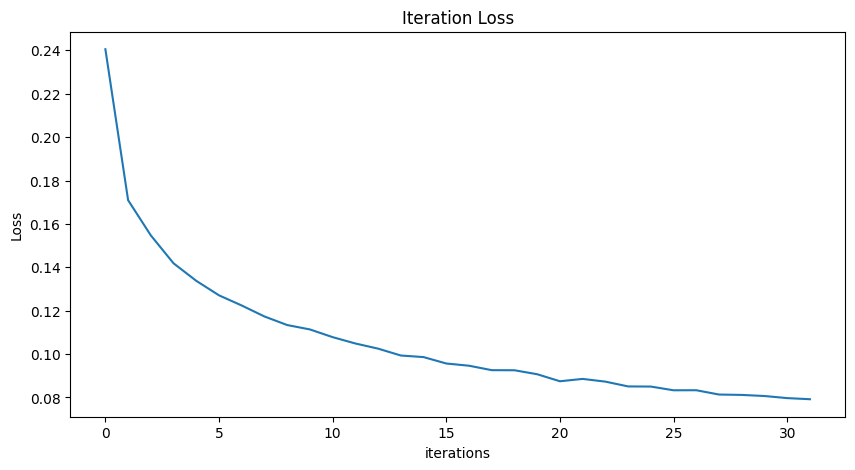

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.title("Iteration Loss")
plt.show()

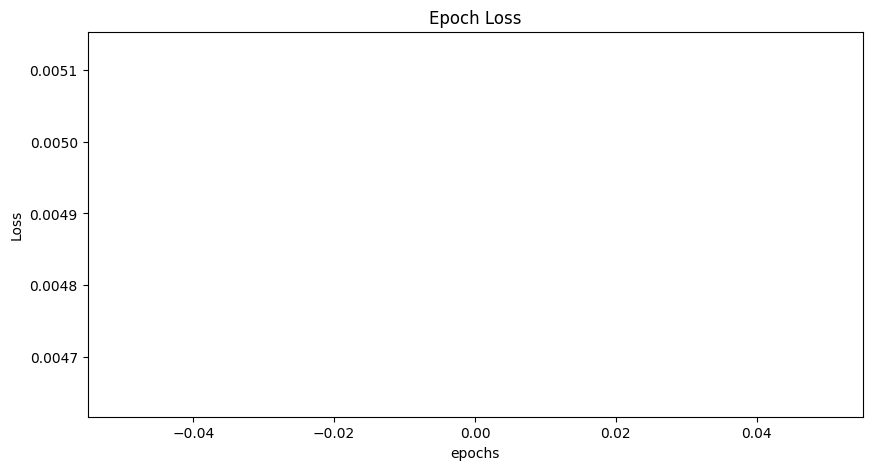

In [17]:
ep_loss = []

for i in range(0, len(train_loss), len(dataloader)):
    ep_loss.append(sum(train_loss[i:i+len(dataloader)])/len(dataloader))

plt.figure(figsize=(10, 5))
plt.plot(ep_loss)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Epoch Loss")
plt.show()

In [18]:
# helper function; removes the predicted noise (but adds some noise back in to avoid collapse)
def denoise_add_noise(images, timestep, pred_noise, b_t, a_t, ab_t, z):

    extra_noise = b_t.sqrt()[timestep] * z
    denoised_img = (images - pred_noise * ((1 - a_t[timestep]) / (1 - ab_t[timestep]).sqrt())) / a_t[timestep].sqrt()

    return denoised_img + extra_noise


# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(n_sample, img_dim, color_dim, b_t, a_t, ab_t, save_rate=20):

    # Sample initial noise from uniform distribution. Size: bs x 3 x img_dim x img_dim
    samples = torch.randn(n_sample, color_dim, img_dim, img_dim).to(device)

    # Backloop from timesteps to 1
    intermediate = []
    for i in tqdm(range(NUM_TIMESTEPS, 0, -1)):

        # reshape normalized time tensor from shape [1] to [1, 1, 1, 1]
        t = torch.tensor([i / NUM_TIMESTEPS])[:, None, None, None].to(device)


        # sample some random noise to inject back in. For i = 1 (last step), don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t)                                                  # predict noise
        samples = denoise_add_noise(samples, i, eps, b_t, a_t, ab_t, z)             # substract the predicted noise and add the extra noise

        if i % save_rate == 0 or i == NUM_TIMESTEPS or i < 8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

Helper function for visualization

In [19]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter


def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani

In [20]:
from IPython.display import HTML

# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{os.path.join(SAVE_DIR, "model_31.pth")}", weights_only=False, map_location=device))
nn_model.eval()
print("Loaded in Model")

# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(32, img_dim, color_dim, b_t, a_t, ab_t, save_rate=20)

animation_ddpm = plot_sample(intermediate_ddpm,32,4,SAVE_DIR, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

Loaded in Model


100%|██████████| 500/500 [00:03<00:00, 162.99it/s]


<Figure size 640x480 with 0 Axes>